# Analysis - WHOI awards
Created by Ivan Lima on Tue Aug 18 2020 21:05:03 -0400

WHOI is the top organization in terms of number of awards (13.9% of total) and the second largest in terms of total amount awarded (16.3% of total). In this notebook we examine gender differences in the NSF awards that went to WHOI.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from tqdm import tnrange, notebook
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 100
pd.options.display.max_columns = 50
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Tue Aug 18 22:20:34 2020


Read NSF award data.

In [2]:
data_types = {'Abstract':'string', 'Title':'string', 'Programs':'string', 'PI':'string',
              'Organization':'string', 'State':'string', 'Instrument':'string', 'co-PIs':'string',
              'program':'string', 'PI_first_name':'string', 'co-PI_first_name':'string',
              'PI_gender':'string', 'co-PI_gender':'string'}
awards = pd.read_csv('results/awards_1985-2020_clean_edited_grouped_gender_topic.csv', index_col=0,
                     parse_dates=[4,5], dtype=data_types)

awards['year'] = awards.StartDate.dt.year
# set award types
awards.loc[awards.Title.str.contains('collaborative\s'),'award_type'] = 'Collaborative Research'
awards.loc[awards.Title.str.contains('eager\s'),'award_type'] = 'EAGER'
awards.loc[awards.Title.str.contains('rapid\s'),'award_type'] = 'RAPID'
awards.loc[awards.Title.str.contains('sger\s'),'award_type'] = 'EAGER'
awards.loc[awards.Title.str.contains('reu\s'),'award_type'] = 'REU'
awards.loc[awards.Title.str.contains('rui\s'),'award_type'] = 'RUI'
awards.loc[awards.Title.str.contains('career\s'),'award_type'] = 'CAREER'
awards.loc[awards.Title.str.contains('cmg\s'),'award_type'] = 'CMG'
awards.loc[awards.Title.str.contains('powre\s'),'award_type'] = 'POWRE'
awards['award_type'] = awards.award_type.fillna('standard')

topic_probs = pd.read_csv('results/topic_probs.csv', index_col=0)
topic_words = pd.read_csv('results/topic_words.csv', index_col=0)

npzfile = np.load('results/NMF_TSNE.npz')
feature_names  = npzfile['feature_names']
nmf_components = npzfile['nmf_components']
topic_names    = npzfile['topic_names']
topic_names_r  = npzfile['topic_names_r']
X_tsne         = npzfile['X_tsne']
npzfile.close()

The figure below shows the number of awards and the amount awarded by NSF Ocean Sciences to WHOI per year, and a box plot of the amount awarded to individual projects in each year between 1987 and 2019.

mean = $65,858,285.10 per year


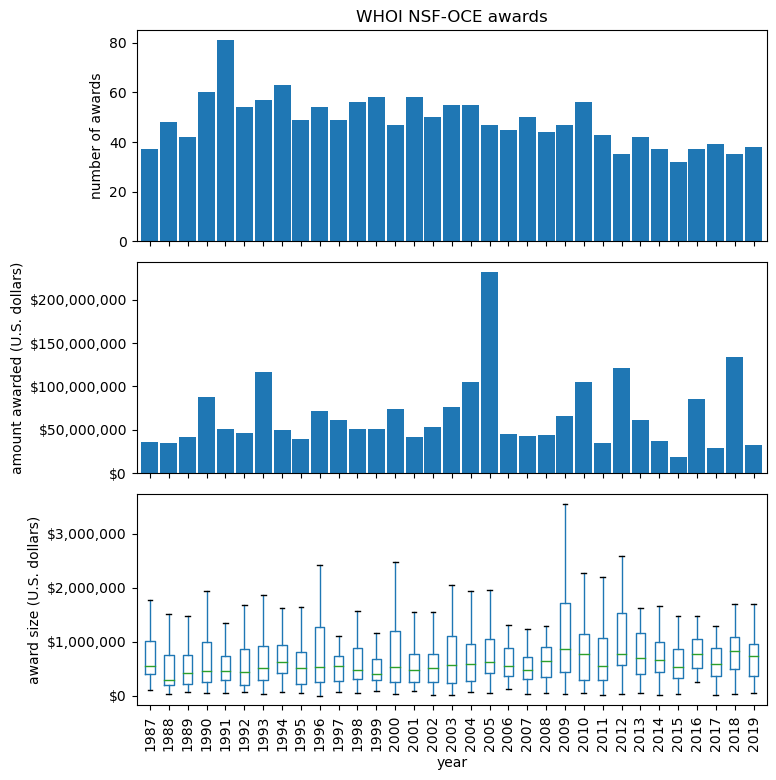

In [3]:
from matplotlib import ticker
def dollar(x, pos):
    return '${:,.0f}'.format(x)
fmt = ticker.FuncFormatter(dollar)

whoi_awards = awards[awards.Organization == 'Woods Hole Oceanographic Institution']
num_awards_per_year_whoi = whoi_awards.groupby([whoi_awards.StartDate.dt.year])['Abstract'].count()
amount_per_year_whoi = whoi_awards.groupby(whoi_awards.StartDate.dt.year)['tot_amount_adjusted'].sum()

fig, axs = plt.subplots(3, 1, figsize=(9,9))
_ = num_awards_per_year_whoi.plot(kind='bar',ax=axs[0], width=0.9, legend=False)
_ = axs[0].set(title='WHOI NSF-OCE awards', ylabel='number of awards', xticklabels='', xlabel='')
_ = amount_per_year_whoi.plot(kind='bar',ax=axs[1], width=0.9)
_ = axs[1].yaxis.set_major_formatter(fmt)
_ = axs[1].set(ylabel='amount awarded (U.S. dollars)', xticklabels='', xlabel='')
_ = whoi_awards.boxplot('tot_amount_adjusted', by='year', showfliers=False,rot=90, grid=False, ax=axs[2])
_ = axs[2].yaxis.set_major_formatter(fmt)
_ = axs[2].set(title='', ylabel='award size (U.S. dollars)')
_ = axs[2].set_xlim(0.3, 33.7)
fig.subplots_adjust(left=0.2, hspace=0.1)
fig.suptitle('')
print('mean = ${:,.2f} per year'.format(amount_per_year_whoi.mean()))

The figure below shows the time series of the annual fraction of female PIs and co-PIs across all WHOI awards. Solid lines represent a 3-year sliding window average and points represent the individual years.

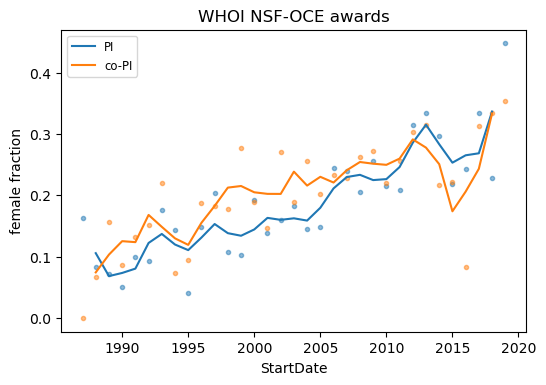

In [4]:
# female & male fraction of PIs
whoi_pi_gender = whoi_awards.groupby([whoi_awards.StartDate.dt.year,
                                      'PI_gender'])['Abstract'].count().unstack()
whoi_pi_gender = whoi_pi_gender.divide(whoi_pi_gender.sum(axis=1), axis=0)

# female & male fraction of co-PIs
whoi_copi_gender = pd.DataFrame({'female':whoi_awards.groupby(whoi_awards.StartDate.dt.year)
                                 ['co-PI_female_frac'].mean()})
whoi_copi_gender['male'] = 1 - whoi_copi_gender.female

# female fraction of PIs & co-PIs
whoi_female_frac = pd.DataFrame({'PI':whoi_pi_gender['female'], 'co-PI':whoi_copi_gender['female']})
fig, ax = plt.subplots()
# _ = whoi_female_frac.plot(ax=ax)
_ = whoi_female_frac.plot(ax=ax, style=['C0.','C1.'],legend=False, alpha=0.5)
_ = whoi_female_frac.rolling(3,center=True).mean().plot(ax=ax)
_ = ax.set(title='WHOI NSF-OCE awards',ylabel='female fraction')

### Top 10 programs in number of awards at WHOI

The table and histogram below show the top 10 NSF-OCE programs at WHOI in number of awards for the period 1987-2019.

In [5]:
whoi_top10_programs = pd.DataFrame({'number of awards':
                                    whoi_awards.groupby('program')['Abstract'].count().sort_values(
                                        ascending=False)[:10]})
whoi_top10_programs['percentage of total'] = whoi_top10_programs['number of awards'] / len(awards) * 100
whoi_top10_programs

,number of awards,percentage of total
program,,
MARINE GEOLOGY AND GEOPHYSICS,398,3.456962
PHYSICAL OCEANOGRAPHY,353,3.066099
CHEMICAL OCEANOGRAPHY,223,1.936941
BIOLOGICAL OCEANOGRAPHY,212,1.841397
OCEAN TECH & INTERDISC COORDIN,100,0.868583
OCEANOGRAPHIC INSTRUMENTATION,47,0.408234
SHIPBOARD SCIENTIFIC SUPP EQUI,37,0.321376
OCEAN DRILLING PROGRAM,32,0.277947
MAJOR RESEARCH INSTRUMENTATION,21,0.182403


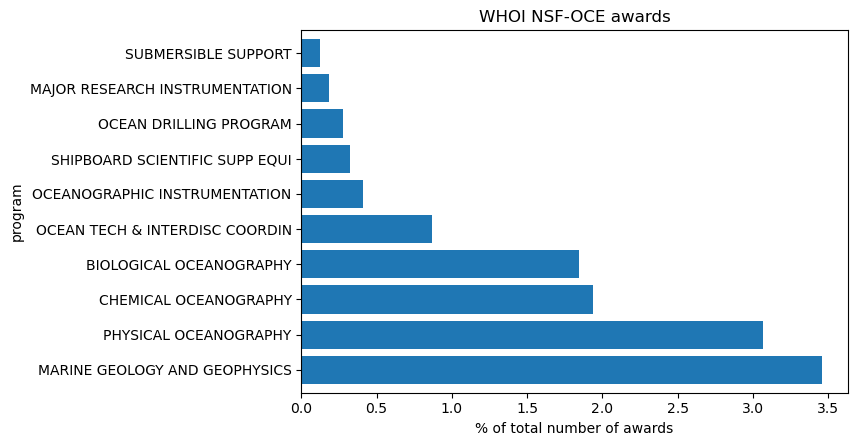

In [6]:
fig, ax = plt.subplots(figsize=(9.5, 4.8))
fig.subplots_adjust(left=0.325)
_ = whoi_top10_programs['percentage of total'].plot(kind='barh',ax=ax, width=0.8)
_ = ax.set(title='WHOI NSF-OCE awards', xlabel='% of total number of awards')

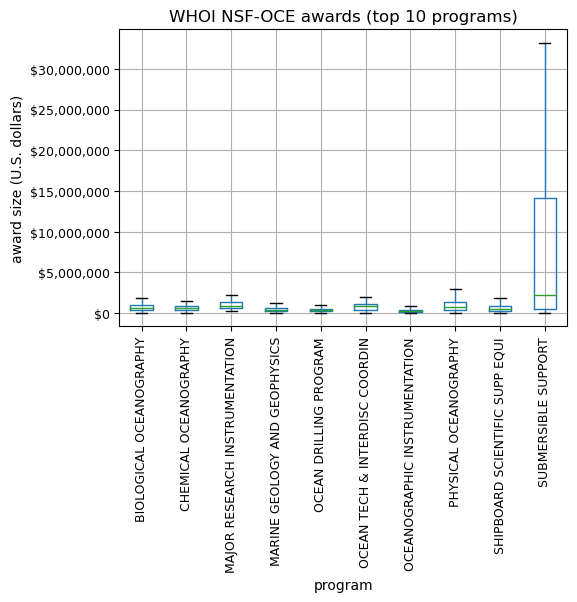

In [7]:
df = whoi_awards[whoi_awards.program.isin(whoi_top10_programs.index)]
fig, ax = plt.subplots(figsize=(6.4, 6.6))
_ = df.boxplot('tot_amount_adjusted', by='program', showfliers=False, rot=90, fontsize=9, ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set(title='WHOI NSF-OCE awards (top 10 programs)', ylabel='award size (U.S. dollars)')
fig.suptitle('')
fig.subplots_adjust(left=0.2, bottom=0.45)

The figure below shows time series of the percentage of awards per year for each of the top 10 NSF-OCE programs at WHOI (in number of awards).

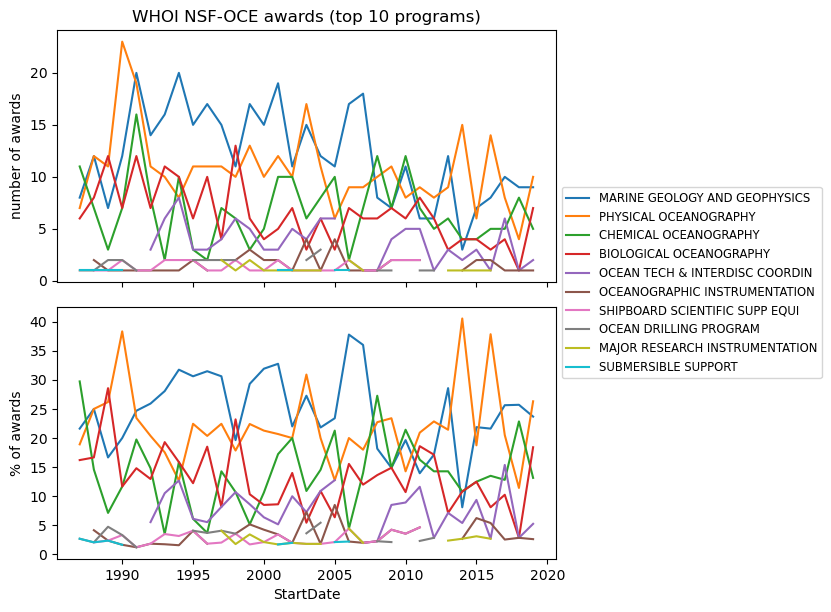

In [8]:
whoi_prog_year = whoi_awards.groupby([whoi_awards.StartDate.dt.year,'program'])['Abstract'].count().unstack()
whoi_prog_year = whoi_prog_year[whoi_top10_programs.index]
whoi_prog_year_pct = whoi_prog_year.divide(num_awards_per_year_whoi, axis=0) * 100

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9.5,7))
fig.subplots_adjust(right=0.65, hspace=0.1)
_ = whoi_prog_year.plot(ax=axs[0], legend=False)
_ = axs[0].set_ylabel('number of awards')
_ = axs[0].set_title('WHOI NSF-OCE awards (top 10 programs)')
_ = whoi_prog_year_pct.plot(ax=axs[1]).legend(bbox_to_anchor=(1, 1.5))
_ = axs[1].set_ylabel('% of awards')

### Top 10 programs in amount awarded to WHOI

The table and histogram below show the top 10 NSF-OCE programs at WHOI in total amount awarded for the period 1987-2019.

In [9]:
whoi_top10_progs_amount = pd.DataFrame({'amount awarded':
                                        whoi_awards.groupby('program')
                                        ['tot_amount_adjusted'].sum().sort_values(ascending=False)[:10]})
whoi_top10_progs_amount['percentage of total'] = (whoi_top10_progs_amount['amount awarded'] /
                                           whoi_awards.tot_amount_adjusted.sum() * 100)
whoi_top10_progs_amount.style.format('${0:,.2f}', subset='amount awarded')

,amount awarded,percentage of total
program,,
PHYSICAL OCEANOGRAPHY,"$488,980,300.89",22.499196
MARINE GEOLOGY AND GEOPHYSICS,"$349,974,695.94",16.103204
BIOLOGICAL OCEANOGRAPHY,"$299,215,442.45",13.767645
CHEMICAL OCEANOGRAPHY,"$155,031,388.07",7.133379
SHIP OPERATIONS,"$117,652,906.72",5.413502
SUBMERSIBLE SUPPORT,"$110,985,969.24",5.106740
OCEAN TECH & INTERDISC COORDIN,"$88,326,099.24",4.064103
ARC RSCH SUPPORT & LOGISTICS,"$76,672,826.91",3.527907
OCEAN OBSERVATORIES INITIATIVE,"$71,206,955.34",3.276409


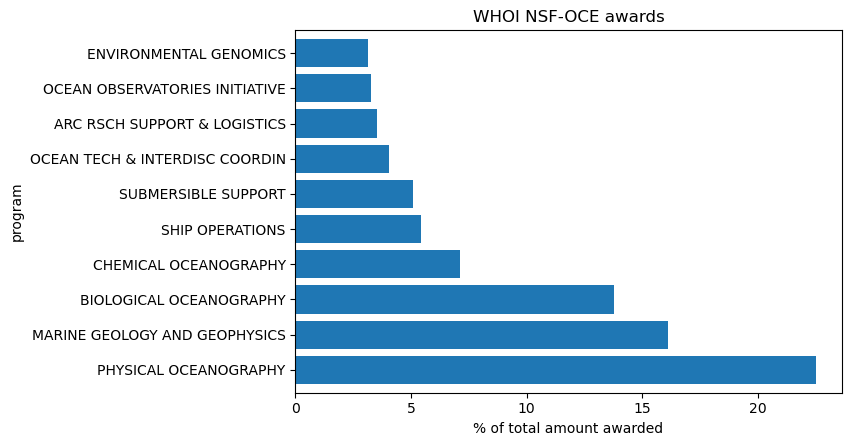

In [10]:
fig, ax = plt.subplots(figsize=(9.5, 4.8))
fig.subplots_adjust(left=0.325)
_ = whoi_top10_progs_amount['percentage of total'].plot(kind='barh',ax=ax, width=0.8)
_ = ax.set(title='WHOI NSF-OCE awards', xlabel='% of total amount awarded')

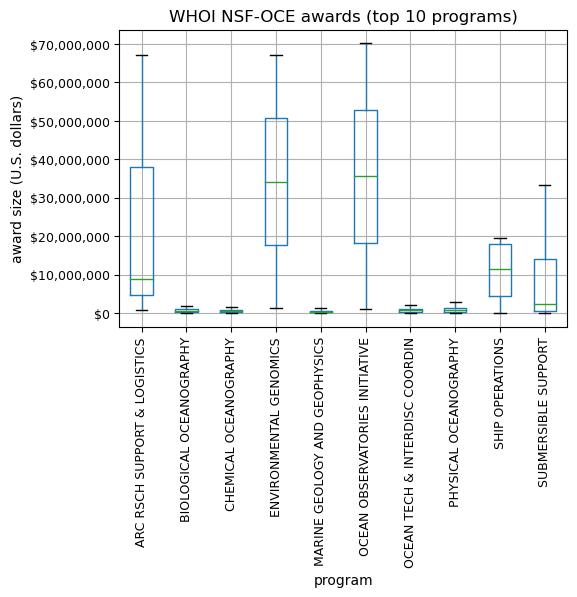

In [11]:
df = whoi_awards[whoi_awards.program.isin(whoi_top10_progs_amount.index)]
fig, ax = plt.subplots(figsize=(6.4, 6.6))
_ = df.boxplot('tot_amount_adjusted', by='program', showfliers=False, rot=90, fontsize=9, ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set(title='WHOI NSF-OCE awards (top 10 programs)', ylabel='award size (U.S. dollars)')
fig.suptitle('')
fig.subplots_adjust(left=0.2, bottom=0.45)

The figure below shows time series of the amount awarded per year for each of the top 10 NSF-OCE programs at WHOI (in amount awarded).

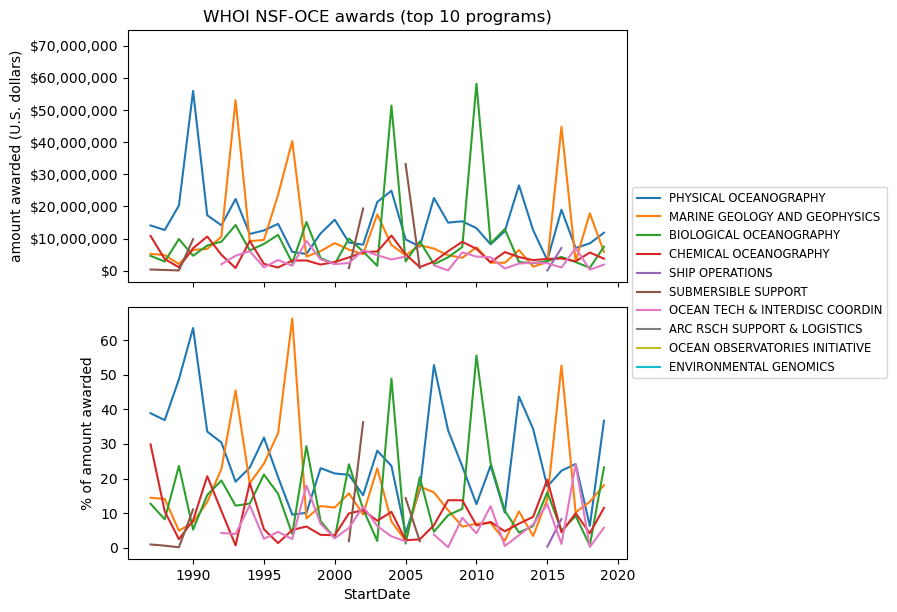

In [12]:
whoi_prog_year_amount = whoi_awards.groupby(
    [whoi_awards.StartDate.dt.year,'program'])['tot_amount_adjusted'].sum().unstack()
whoi_prog_year_amount = whoi_prog_year_amount[whoi_top10_progs_amount.index]
whoi_prog_year_amount_pct = whoi_prog_year_amount.divide(amount_per_year_whoi, axis=0) * 100

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9.5,7))
fig.subplots_adjust(right=0.65, hspace=0.1)
_ = whoi_prog_year_amount.plot(ax=axs[0], legend=False)
_ = axs[0].set_ylabel('amount awarded (U.S. dollars)')
_ = axs[0].set_title('WHOI NSF-OCE awards (top 10 programs)')
_ = axs[0].yaxis.set_major_formatter(fmt)
_ = whoi_prog_year_amount_pct.plot(ax=axs[1]).legend(bbox_to_anchor=(1, 1.5))
_ = axs[1].set_ylabel('% of amount awarded')

### WHOI award types

In [13]:
atypes_whoi = pd.DataFrame({'number of awards': whoi_awards.award_type.value_counts()})
atypes_whoi['percentage of total'] =  atypes_whoi['number of awards'] / len(whoi_awards) * 100
atypes_whoi

,number of awards,percentage of total
standard,1255,78.4375
Collaborative Research,259,16.1875
EAGER,42,2.6250
RAPID,22,1.3750
REU,12,0.7500
CAREER,5,0.3125
CMG,3,0.1875
RUI,1,0.0625
POWRE,1,0.0625


In [14]:
atype_whoi_amount = pd.DataFrame(
    {'amount awarded':
     whoi_awards.groupby('award_type')['tot_amount_adjusted'].sum().sort_values(ascending=False)})
atype_whoi_amount['percentage of total'] = (atype_whoi_amount['amount awarded'] / 
                                            atype_whoi_amount['amount awarded'].sum() * 100)
atype_whoi_amount.style.format('${0:,.2f}', subset='amount awarded')

,amount awarded,percentage of total
award_type,,
standard,"$1,825,733,906.42",84.006545
Collaborative Research,"$320,824,301.72",14.761922
REU,"$8,677,883.79",0.399291
RAPID,"$5,123,242.16",0.235733
EAGER,"$4,525,663.93",0.208237
CAREER,"$4,421,981.64",0.203466
CMG,"$3,158,872.84",0.145348
RUI,"$739,059.74",0.034006
POWRE,"$118,495.98",0.005452


### Changes in gender composition across top 10 programs (in number of awards) at WHOI

The figure below shows time series of the annual fraction of female PIs and co-PIs for each of the top 10 programs in number of awards at WHOI. Solid lines represent a 3-year sliding window average and points represent the individual years.

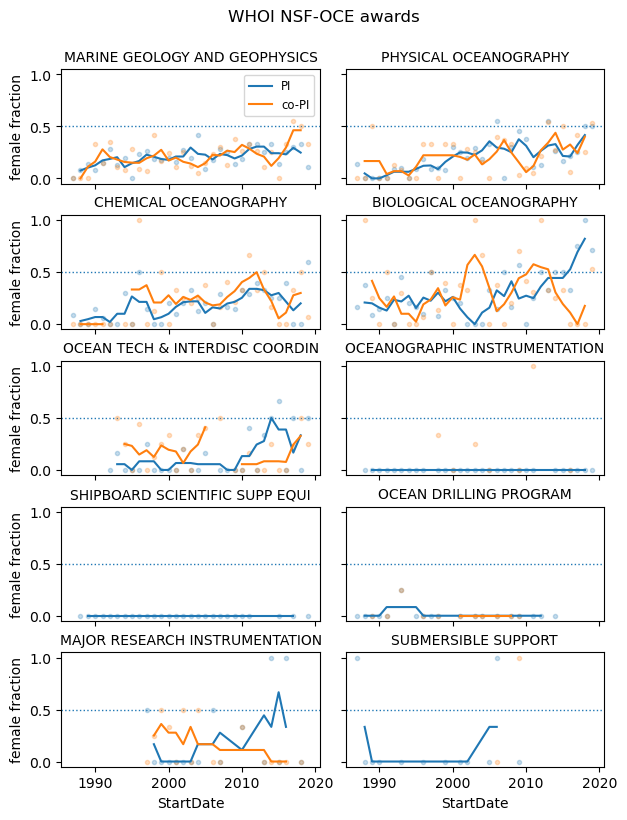

In [15]:
# female & male fraction of PIs
df_prog = whoi_awards[whoi_awards.program.isin(whoi_top10_programs.index)]
df = df_prog.groupby(['program',df_prog.StartDate.dt.year,'PI_gender'])['Abstract'].count().unstack()
whoi_pi_gender_by_program = df.fillna(0).divide(df.sum(axis=1), axis=0)

# female & male fraction of co-PIs
whoi_copi_gender_by_program = pd.DataFrame({'female': 
                                            df_prog.groupby(['program',df_prog.StartDate.dt.year])
                                            ['co-PI_female_frac'].mean()})
whoi_copi_gender_by_program['male'] = 1 - whoi_copi_gender_by_program.female

# female fraction of PIs & co-PIs
whoi_female_frac_by_program = pd.DataFrame({'PI':whoi_pi_gender_by_program['female'],
                                            'co-PI':whoi_copi_gender_by_program['female']})

nn = 3 # size of moving window (years)
alpha = 0.25

fig, axs = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(7, 9))
fig.subplots_adjust(hspace=0.275, wspace=0.1, top=0.9)
for ax, prog in zip(axs.ravel(), whoi_top10_programs.index):
    if prog == 'MARINE GEOLOGY AND GEOPHYSICS':
        legend = True
    else:
        legend=False
    _ = whoi_female_frac_by_program.loc[prog].plot(ax=ax, style=['C0.','C1.'],legend=False, alpha=alpha)
    _ = whoi_female_frac_by_program.loc[prog].rolling(nn, center=True).mean().plot(ax=ax, legend=legend)
    _ = ax.set_title(prog, fontsize=10)
    x0, x1 = ax.get_xlim()
    _ = ax.hlines(0.5, x0, x1, linestyles='dotted', linewidth=1)
    _ = ax.set_xlim(x0,x1)    
for i in range(5):
    _ = axs[i,0].set_ylabel('female fraction')
_ = fig.text(0.5,0.95,'WHOI NSF-OCE awards', ha='center', va='bottom', fontsize=12)

### Changes in gender composition across research topics at WHOI

The figure below shows time series of the annual fraction of female PIs and co-PIs for each of the research topics at WHOI. Solid lines represent a 3-year sliding window average and points represent the individual years. The number of awards per year in each topic is small (<10), therefore the high variability from year to year.

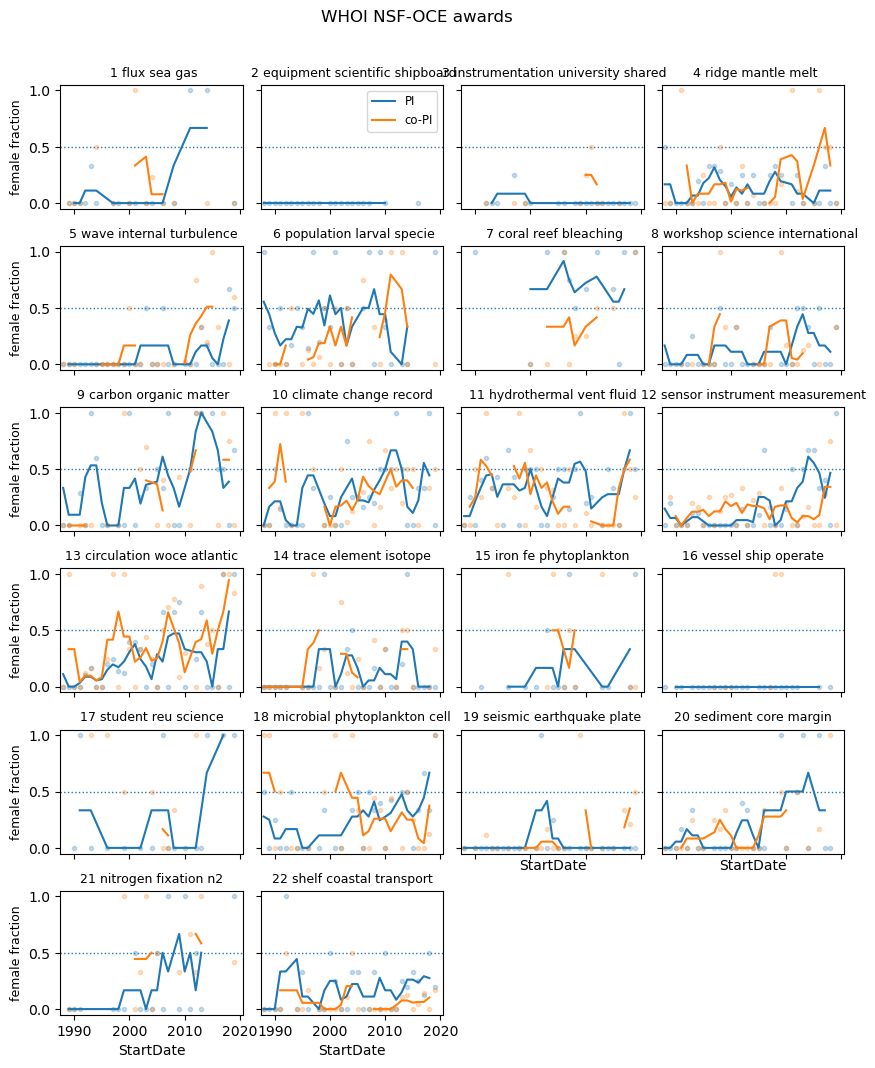

In [16]:
df = whoi_awards.groupby(['topic',whoi_awards.StartDate.dt.year,'PI_gender'])['Abstract'].count().unstack()
whoi_pi_gender_by_topic = df.fillna(0).divide(df.sum(axis=1), axis=0)

whoi_copi_gender_by_topic = pd.DataFrame(
    {'female':whoi_awards.groupby(['topic', whoi_awards.StartDate.dt.year])['co-PI_female_frac'].mean()})
whoi_copi_gender_by_topic['male'] = 1 - whoi_copi_gender_by_topic.female
whoi_copi_gender_by_topic

whoi_female_frac_by_topic = pd.DataFrame({'PI':whoi_pi_gender_by_topic.female,
                                          'co-PI':whoi_copi_gender_by_topic.female})

fig, axs = plt.subplots(6, 4, sharex=True, sharey=True, figsize=(9.5,12))
fig.subplots_adjust(hspace=0.3, wspace=0.1, top=0.9, right=0.95)
fig.delaxes(axs[5,3])
fig.delaxes(axs[5,2])
for ax, t in zip(axs.ravel(), range(1,23)):
    if t == 2:
        legend = True
    else:
        legend=False    
#     _ = whoi_female_frac_by_topic.loc[t].plot(ax=ax, legend=legend)
    _ = whoi_female_frac_by_topic.loc[t].plot(ax=ax, style=['C0.','C1.'], legend=False, alpha=0.25)
    _ = whoi_female_frac_by_topic.loc[t].rolling(nn,center=True).mean().plot(ax=ax, legend=legend)
    _ = ax.set_title(topic_names_r[t-1], fontsize=9)
    x0, x1 = ax.get_xlim()
    _ = ax.hlines(0.5, x0, x1, linestyles='dotted', linewidth=1)
    _ = ax.set_xlim(x0,x1)
for i in range(6):
    _ = axs[i,0].set_ylabel('female fraction', fontsize=9)
_ = fig.text(0.5,0.95,'WHOI NSF-OCE awards', ha='center', va='bottom', fontsize=12)

### Changes in gender composition across award types

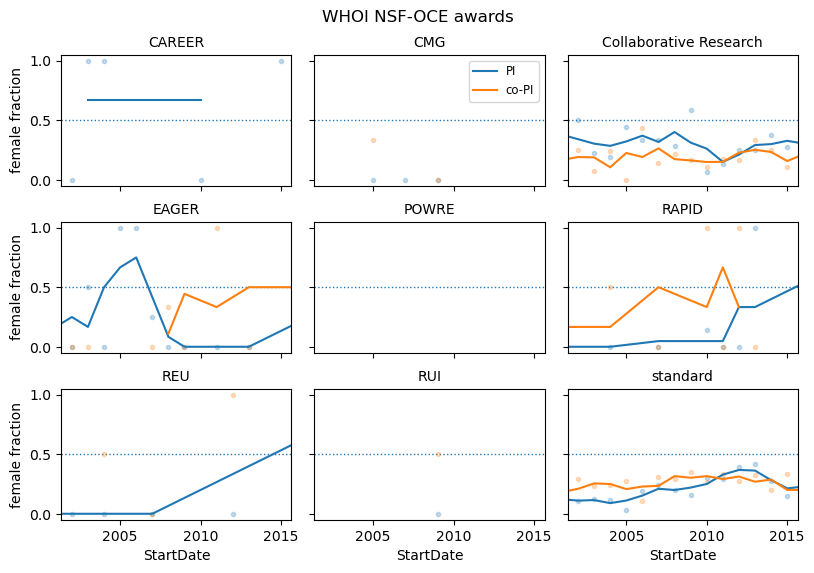

In [17]:
# female & male fraction of PIs
df = whoi_awards.groupby(['award_type',
                          whoi_awards.StartDate.dt.year,'PI_gender'])['Abstract'].count().unstack()
pi_gender_whoi_by_atype = df.fillna(0).divide(df.sum(axis=1), axis=0)

# female & male fraction of co-PIs
copi_gender_whoi_by_atype = pd.DataFrame({
    'female': whoi_awards.groupby(['award_type',whoi_awards.StartDate.dt.year])['co-PI_female_frac'].mean()})
copi_gender_whoi_by_atype['male'] = 1 - copi_gender_whoi_by_atype.female

female_frac_whoi_by_atype = pd.DataFrame({'PI':pi_gender_whoi_by_atype['female'],
                                          'co-PI': copi_gender_whoi_by_atype['female']})

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(9.5, 6))
fig.subplots_adjust(hspace=0.275, wspace=0.1, top=0.9)
for ax, atype in zip(axs.ravel(), female_frac_whoi_by_atype.index.levels[0]):
    if atype == 'CMG':
        legend = True
    else:
        legend=False
    _ = female_frac_whoi_by_atype.loc[atype].plot(ax=ax, style=['C0.','C1.'], legend=False, alpha=alpha)
    _ = female_frac_whoi_by_atype.loc[atype].rolling(nn,center=True).mean().plot(ax=ax, legend=legend)
    _ = ax.set_title(atype, fontsize=10)
    x0, x1 = ax.get_xlim()
    _ = ax.hlines(0.5, x0, x1, linestyles='dotted', linewidth=1)
    _ = ax.set_xlim(x0,x1)    
for i in range(3):
    _ = axs[i,0].set_ylabel('female fraction')
_ = fig.text(0.5,0.95,'WHOI NSF-OCE awards', ha='center', va='bottom', fontsize=12)